In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import keras
import tensorflow as tf 
print(tf.__version__)
print(keras.__version__)
print(pd.__version__)
print(np.__version__)
# Script Imports
from nn_globals import *
from nn_plotting import __generate_delta_plots__
from dataset import muon_data_split
from nn_evaluate import huber_loss, k_fold_validation
from nn_training import train_model, lr_schedule
# Keras/TF import
from keras.models import Model, load_model
from keras.regularizers import L1L2
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, BatchNormalization, Dense, Activation
from keras.callbacks import LearningRateScheduler, TerminateOnNaN, ModelCheckpoint, EarlyStopping

2.6.0
2.6.0
1.3.4
1.19.5


In [2]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ= muon_data_split(filename=DATAFILEPATH, 
                                                                                                           reg_pt_scale=REG_PT_SCALE, 
                                                                                                           reg_dxy_scale=REG_DXY_SCALE, 
                                                                                                           test_size=TEST_SIZE,
                                                                                                           nvariables = NVARIABLES,
                                                                                                           nentries= NENTRIES,
                                                                                                           batch_size = 128)


[INFO    ] Loading muon data from ./data/NN_input_params_FlatXYZ.npz ...
[INFO    ] Loaded the variables with shape (19300000, 25)
[INFO    ] Loaded the parameters with shape (19300000, 6)
[INFO    ] Loaded the encoded variables with shape (3284620, 23)
[INFO    ] Loaded the encoded parameters with shape (3284620,)
[INFO    ] Loaded # of training and testing events: (2249964, 1034656)
[WARNING ] The last batch for training could be too few! (2024967%128)=7. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*0.9) % 128
[WARNING ] The last batch for training after mixing could be too few! (4049935%128)=15. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*2*0.9) % 128


In [3]:
def create_model(nvariables, lr=0.001, clipnorm=10., initializer = "glorot_uniform",
                nodes1=64, nodes2=32, nodes3=16, outnodes=2,
                l1_reg = 0.0, l2_reg = 0.0):
  
    regularizer = L1L2(l1=l1_reg, l2=l2_reg)
    bn_momentum = 0.9
    eps = 1e-4

    x = x_in = Input((nvariables,))
    x = BatchNormalization(epsilon=eps, momentum=bn_momentum,name="bn-input")(x)
    
    x = Dense(nodes1, 
               kernel_initializer=initializer,
               use_bias = False,
               kernel_regularizer = regularizer,
               name="hidden-dense-1")(x)
    x = BatchNormalization(epsilon = eps, momentum  = bn_momentum, name = "bn-1")(x)
    x = Activation(activation = "tanh",name="act_1")(x)
    
    if nodes2:
    
        x = Dense(nodes2, 
                   kernel_initializer=initializer,
                   use_bias = False,
                   kernel_regularizer = regularizer,
                   name="hidden-dense-2")(x)
        x = BatchNormalization(epsilon = eps, momentum  = bn_momentum, name = "bn-2")(x)
        x = Activation(activation = "tanh",name="act_2")(x)
        if nodes3:

            x = Dense(nodes3, 
                       kernel_initializer=initializer,
                       kernel_regularizer = regularizer,
                       use_bias = False,
                       name="hidden-dense-3")(x)
            x = BatchNormalization(epsilon = eps, momentum  = bn_momentum, name = "bn-3")(x)
            x = Activation(activation = "tanh", name="act_3")(x)

    x = Dense(outnodes,kernel_initializer = initializer,name="dense-output")(x)
    x = Activation("linear")(x)
    
    model = Model(inputs=x_in, outputs=x,name="baseline-model")
    
    adam = Adam(lr=lr, clipnorm=clipnorm)
    model.compile(optimizer=adam, 
                  loss=huber_loss, 
                  metrics=['acc','mse','mae'])
    model.summary()
    
    return model
    

In [15]:
assert(keras.backend.backend() == 'tensorflow')

normal_epochs = 300
normal_batch_size = 1000
l1_reg = 0.0
l2_reg = 0.0
learning_rate = 0.05
gradient_clip_norm = 100.

lr_decay = LearningRateScheduler(lr_schedule, verbose=1)
terminate_on_nan = TerminateOnNaN()
model_training_checkpoint = ModelCheckpoint(monitor="val_loss", 
                                           verbose = 1,
                                           filepath = "checkpoints/model_ckpt_epoch_{epoch:02d}.hdf5",
                                           period = 10)
early_stopping = EarlyStopping(monitor = "val_loss", 
                                               min_delta= 1e-5, 
                                               mode = "auto", 
                                               patience = 10)

model = create_model(
                    nvariables = NVARIABLES, 
                    lr = learning_rate, 
                    clipnorm = gradient_clip_norm, 
                    nodes1=10, 
                    nodes2=7, 
                    nodes3=5, 
                    outnodes=2,
                    l1_reg = l1_reg, 
                    l2_reg = l2_reg)

logger.info('Training model with l1_reg: {0} l2_reg: {1}'.format(l1_reg, l2_reg))

model, history = train_model(model, 
                      x_train_displ, 
                      np.column_stack((y_train_displ, dxy_train_displ)),
                      save_model=False, 
                      epochs=normal_epochs, 
                      batch_size=normal_batch_size,
                      callbacks=[lr_decay,terminate_on_nan, model_training_checkpoint], 
                      validation_split=0.1, 
                      verbose=True)

metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]]
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(*metrics))

[INFO    ] Training model with l1_reg: 0.0 l2_reg: 0.0
[INFO    ] Begin training ...


Model: "baseline-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
bn-input (BatchNormalization (None, 23)                92        
_________________________________________________________________
hidden-dense-1 (Dense)       (None, 10)                230       
_________________________________________________________________
bn-1 (BatchNormalization)    (None, 10)                40        
_________________________________________________________________
act_1 (Activation)           (None, 10)                0         
_________________________________________________________________
hidden-dense-2 (Dense)       (None, 7)                 70        
_________________________________________________________________
bn-2 (BatchNormalization)    (None, 7)              

2022-01-11 16:50:24.802376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2025/2025 [==============================] - ETA: 0s - loss: 14.9906 - acc: 0.9247 - mse: 348.6965 - mae: 11.7935

2022-01-11 16:50:54.930642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2025/2025 [==============================] - 31s 15ms/step - loss: 14.9906 - acc: 0.9247 - mse: 348.6965 - mae: 11.7935 - val_loss: 12.3924 - val_acc: 0.9334 - val_mse: 209.0125 - val_mae: 9.8593
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 0.05000000074505806.
2025/2025 [==============================] - 30s 15ms/step - loss: 11.7682 - acc: 0.9307 - mse: 195.4521 - mae: 9.3938 - val_loss: 11.6826 - val_acc: 0.9342 - val_mse: 194.5160 - val_mae: 9.3302
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 0.05000000074505806.
2025/2025 [==============================] - 30s 15ms/step - loss: 11.5659 - acc: 0.9321 - mse: 191.2361 - mae: 9.2424 - val_loss: 11.3635 - val_acc: 0.9347 - val_mse: 187.6433 - val_mae: 9.0913
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 0.05000000074505806.
2025/2025 [==============================] - 30s 15ms/step - loss: 11.5146 - acc: 0.9322 - mse: 190.3987 - mae: 9.2041 - val_loss: 1

2025/2025 [==============================] - 30s 15ms/step - loss: 11.2248 - acc: 0.9341 - mse: 184.9808 - mae: 8.9871 - val_loss: 11.1579 - val_acc: 0.9370 - val_mse: 183.6069 - val_mae: 8.9367
Epoch 30/300

Epoch 00030: LearningRateScheduler setting learning rate to 0.04050000011920929.
2025/2025 [==============================] - 30s 15ms/step - loss: 11.2281 - acc: 0.9339 - mse: 184.9450 - mae: 8.9895 - val_loss: 11.2776 - val_acc: 0.9362 - val_mse: 186.9651 - val_mae: 9.0261

Epoch 00030: saving model to checkpoints/model_ckpt_epoch_30.hdf5
Epoch 31/300

Epoch 00031: LearningRateScheduler setting learning rate to 0.03645000010728836.
2025/2025 [==============================] - 34s 17ms/step - loss: 11.2143 - acc: 0.9340 - mse: 184.8260 - mae: 8.9791 - val_loss: 10.9192 - val_acc: 0.9357 - val_mse: 178.7287 - val_mae: 8.7584
Epoch 32/300

Epoch 00032: LearningRateScheduler setting learning rate to 0.03644999861717224.
2025/2025 [==============================] - 32s 16ms/step - lo

Epoch 57/300

Epoch 00057: LearningRateScheduler setting learning rate to 0.02952449955046177.
2025/2025 [==============================] - 29s 15ms/step - loss: 11.1312 - acc: 0.9342 - mse: 183.0808 - mae: 8.9171 - val_loss: 10.9373 - val_acc: 0.9357 - val_mse: 178.8336 - val_mae: 8.7717
Epoch 58/300

Epoch 00058: LearningRateScheduler setting learning rate to 0.02952449955046177.
2025/2025 [==============================] - 30s 15ms/step - loss: 11.1375 - acc: 0.9340 - mse: 183.2132 - mae: 8.9218 - val_loss: 11.3128 - val_acc: 0.9327 - val_mse: 187.3358 - val_mae: 9.0522
Epoch 59/300

Epoch 00059: LearningRateScheduler setting learning rate to 0.02952449955046177.
2025/2025 [==============================] - 30s 15ms/step - loss: 11.1463 - acc: 0.9341 - mse: 183.3740 - mae: 8.9285 - val_loss: 10.9573 - val_acc: 0.9329 - val_mse: 179.3577 - val_mae: 8.7872
Epoch 60/300

Epoch 00060: LearningRateScheduler setting learning rate to 0.02952449955046177.
2025/2025 [========================

Epoch 112/300

Epoch 00112: LearningRateScheduler setting learning rate to 0.015690527856349945.
2025/2025 [==============================] - 29s 15ms/step - loss: 11.0521 - acc: 0.9342 - mse: 181.6015 - mae: 8.8579 - val_loss: 10.8328 - val_acc: 0.9363 - val_mse: 176.6313 - val_mae: 8.6940
Epoch 113/300

Epoch 00113: LearningRateScheduler setting learning rate to 0.015690527856349945.
2025/2025 [==============================] - 30s 15ms/step - loss: 11.0459 - acc: 0.9343 - mse: 181.4330 - mae: 8.8534 - val_loss: 10.9519 - val_acc: 0.9354 - val_mse: 181.7891 - val_mae: 8.7825
Epoch 114/300

Epoch 00114: LearningRateScheduler setting learning rate to 0.015690527856349945.
2025/2025 [==============================] - 30s 15ms/step - loss: 11.0410 - acc: 0.9343 - mse: 181.2193 - mae: 8.8497 - val_loss: 10.9053 - val_acc: 0.9359 - val_mse: 178.8686 - val_mae: 8.7481
Epoch 115/300

Epoch 00115: LearningRateScheduler setting learning rate to 0.015690527856349945.
2025/2025 [================

2025/2025 [==============================] - 29s 14ms/step - loss: 10.9802 - acc: 0.9348 - mse: 180.1281 - mae: 8.8042 - val_loss: 10.7762 - val_acc: 0.9366 - val_mse: 175.8415 - val_mae: 8.6515
Epoch 167/300

Epoch 00167: LearningRateScheduler setting learning rate to 0.00926509965211153.
2025/2025 [==============================] - 29s 14ms/step - loss: 10.9776 - acc: 0.9347 - mse: 180.1762 - mae: 8.8022 - val_loss: 10.7396 - val_acc: 0.9355 - val_mse: 175.3739 - val_mae: 8.6241
Epoch 168/300

Epoch 00168: LearningRateScheduler setting learning rate to 0.00926509965211153.
2025/2025 [==============================] - 29s 14ms/step - loss: 10.9712 - acc: 0.9347 - mse: 179.9956 - mae: 8.7974 - val_loss: 10.7711 - val_acc: 0.9369 - val_mse: 176.3301 - val_mae: 8.6479
Epoch 169/300

Epoch 00169: LearningRateScheduler setting learning rate to 0.00926509965211153.
2025/2025 [==============================] - 29s 14ms/step - loss: 10.9738 - acc: 0.9347 - mse: 180.1201 - mae: 8.7993 - val_lo

Epoch 194/300

Epoch 00194: LearningRateScheduler setting learning rate to 0.006754257250577211.
2025/2025 [==============================] - 29s 14ms/step - loss: 10.9085 - acc: 0.9354 - mse: 178.8552 - mae: 8.7503 - val_loss: 10.7302 - val_acc: 0.9369 - val_mse: 176.0297 - val_mae: 8.6167
Epoch 195/300

Epoch 00195: LearningRateScheduler setting learning rate to 0.006754257250577211.
2025/2025 [==============================] - 29s 14ms/step - loss: 10.8880 - acc: 0.9354 - mse: 178.3969 - mae: 8.7350 - val_loss: 10.6296 - val_acc: 0.9368 - val_mse: 173.2574 - val_mae: 8.5416
Epoch 196/300

Epoch 00196: LearningRateScheduler setting learning rate to 0.006754257250577211.
2025/2025 [==============================] - 28s 14ms/step - loss: 10.8910 - acc: 0.9355 - mse: 178.4097 - mae: 8.7373 - val_loss: 10.6497 - val_acc: 0.9373 - val_mse: 173.9884 - val_mae: 8.5562
Epoch 197/300

Epoch 00197: LearningRateScheduler setting learning rate to 0.006754257250577211.
2025/2025 [================

Epoch 249/300

Epoch 00249: LearningRateScheduler setting learning rate to 0.003988321404904127.
2025/2025 [==============================] - 29s 14ms/step - loss: 10.7790 - acc: 0.9364 - mse: 175.9784 - mae: 8.6530 - val_loss: 10.5004 - val_acc: 0.9380 - val_mse: 170.7337 - val_mae: 8.4442
Epoch 250/300

Epoch 00250: LearningRateScheduler setting learning rate to 0.003988321404904127.
2025/2025 [==============================] - 29s 14ms/step - loss: 10.7919 - acc: 0.9363 - mse: 176.1705 - mae: 8.6626 - val_loss: 10.5486 - val_acc: 0.9376 - val_mse: 171.8609 - val_mae: 8.4805

Epoch 00250: saving model to checkpoints/model_ckpt_epoch_250.hdf5
Epoch 251/300

Epoch 00251: LearningRateScheduler setting learning rate to 0.0035894892644137144.
2025/2025 [==============================] - 28s 14ms/step - loss: 10.7799 - acc: 0.9365 - mse: 176.0022 - mae: 8.6536 - val_loss: 10.5125 - val_acc: 0.9382 - val_mse: 171.6022 - val_mae: 8.4532
Epoch 252/300

Epoch 00252: LearningRateScheduler setti

2025/2025 [==============================] - 28s 14ms/step - loss: 10.7622 - acc: 0.9365 - mse: 175.5785 - mae: 8.6403 - val_loss: 10.4880 - val_acc: 0.9379 - val_mse: 171.0744 - val_mae: 8.4350
Epoch 277/300

Epoch 00277: LearningRateScheduler setting learning rate to 0.002907486166805029.
2025/2025 [==============================] - 28s 14ms/step - loss: 10.7533 - acc: 0.9365 - mse: 175.4269 - mae: 8.6337 - val_loss: 10.4830 - val_acc: 0.9381 - val_mse: 170.0256 - val_mae: 8.4313
Epoch 278/300

Epoch 00278: LearningRateScheduler setting learning rate to 0.002907486166805029.
2025/2025 [==============================] - 28s 14ms/step - loss: 10.7496 - acc: 0.9365 - mse: 175.3592 - mae: 8.6309 - val_loss: 10.4946 - val_acc: 0.9379 - val_mse: 171.2708 - val_mae: 8.4399
Epoch 279/300

Epoch 00279: LearningRateScheduler setting learning rate to 0.002907486166805029.
2025/2025 [==============================] - 28s 14ms/step - loss: 10.7503 - acc: 0.9366 - mse: 175.3131 - mae: 8.6314 - val

[INFO    ] Done training. Time elapsed: 2:28:13.749738 sec
[INFO    ] Epoch 300/300 - loss: 10.740618705749512 - val_loss: 10.46129322052002



Epoch 00300: saving model to checkpoints/model_ckpt_epoch_300.hdf5


2022-01-11 19:18:38.753058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Mean RMSE for 1-Fold cv for momentum = 52.12346508293483
Mean RMSE for 1-Fold cv for displacement = 17.094939236643718
Mean MAE for 1-Fold cv for momentum = 11.225666081859531
Mean MAE for 1-Fold cv for displacement = 12.051035439779488


[INFO    ] # of entries: 1034656, mean: 0.04872230097123355, std: 0.18677842831551852
[INFO    ] gaus fit (a, mu, sig): [ 5.22447713e+04 -1.05662438e-02  2.61796697e-01]


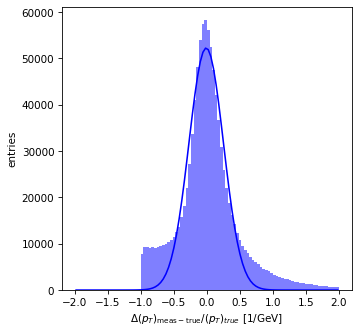

[INFO    ] # of entries: 149864, mean: -0.2786651528813812, std: 10.9846716990604
[INFO    ] gaus fit (a, mu, sig): [ 8.43505192e+03 -3.84070478e-01  6.39581352e+00]


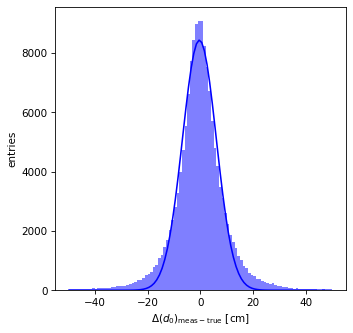

In [16]:
k_fold_validation(model = model,
                  x = x_test_displ,
                  y = y_test_displ,
                  dxy = dxy_test_displ,
                  folds = 1,
                  metric_type = "RMSE")
k_fold_validation(model = model,
                  x = x_test_displ,
                  y = y_test_displ,
                  dxy = dxy_test_displ,
                  folds = 1,
                  metric_type = "MAE")
__generate_delta_plots__(model,
                         x = x_test_displ,
                         y = y_test_displ,
                         dxy = dxy_test_displ,
                         color = "blue")

In [17]:
# from nn_pruning_module_support import saving_model
# saving_model(model = model,
#             filepath = "./models",
#             model_filename = "baseline_reduced_dim_0.5")

Saved model to disk
